#  Flight Planning

The problem we are targetting is to predict the trajectory of an aircraft under forecasted weather conditions.

This problem has been chosen for two reasons:
  - Show how scikit-decide can be used in close to real life use case,
  - Design a specific domain using external packages. In our case, we will use [OpenAP](https://github.com/TUDelft-CNS-ATM/openap) to simulate the dynamics of the aircraft.

Therefore in this notebook we will go through the following steps:
  - Wrap a Gym environment in a scikit-decide domain;
  - Use a classical A*Star algorithm to solve our problem;
  
Notes:

- In order to focus on scikit-decide use, we put some code not directly related to the library in a separate module (weather data download and interpolation).
- This notebook can be long to run as it needs to retrieve a large amount of data

In [ ]:
import warnings
from argparse import Action
from datetime import datetime, timedelta
from enum import Enum
from time import sleep
from typing import Any, NamedTuple, Optional, Tuple, Union

import matplotlib.pyplot as plt
import pandas as pd
from flightplanning_utils import (
    WeatherRetrieverFromEcmwf,
    WindInterpolator,
    flying,
    plot_trajectory,
)
from IPython.display import clear_output
from openap.extra.aero import distance
from openap.extra.nav import airport
from openap.fuel import FuelFlow
from openap.prop import aircraft
from pygeodesy.ellipsoidalVincenty import LatLon

from skdecide import DeterministicPlanningDomain, Space, Value
from skdecide.builders.domain import Renderable, UnrestrictedActions
from skdecide.hub.solver.astar import Astar
from skdecide.hub.space.gym import EnumSpace, ListSpace, MultiDiscreteSpace
from skdecide.utils import match_solvers

# choose standard matplolib inline backend to render plots
%matplotlib inline

One package that we are using (cartopy) is throwing warnings, let's get rid of them

In [ ]:
warnings.filterwarnings("ignore")

## About the Flight Planning problem

In this problem, an aircarft is going from a departure airport to a destination airport. If the weather is not taken into account the optimal (shortest) path would be the [great circle](https://en.wikipedia.org/wiki/Great_circle). When winds come into play the prediction of the trajectory is more complex as we need to take into account the speed of the wind which varies over time. In the real life an aircraft route is defined by a certain number of waypoint the aircraft must go through and flight levels the pilot is supposed to respect. In order to simplify the problem, we will assume our aircraft can follow the directed edges of a graph starting from the destination airport and finishing to the arrival airport.

## Taming weather data 

As discussed earlier we want to see the impact of weather and more specifically wind on the flight path. Therefore we neeed to be able to get the wind velocity for any point of the globe at any flyable altitude and for a given time.

For this we will use utility functions that are defined in `flightplanning_utils.py`

### Defining credentials

The weather data will be retrieved from the [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/home). To enable retrieval you will need to create an account there and store your credentials as follows:

```
key="{your_id}:{your_key}"
```

In [ ]:
key = "123456:aaaaaaaa-bbbb-cccc-dddd-eeeeeeeeeeee"

### Retrieving wind data

The next cell will retrieve the wind information for a given day on the whole planet. This will download approximately `2 GB`of data. Make sure to have a proper connection.

In [ ]:
file = None

if key != "123456:aaaaaaaa-bbbb-cccc-dddd-eeeeeeeeeeee":
    wr = WeatherRetrieverFromEcmwf()

    # Select a date in the past, it takes up to 7 days for the weather data to reach the server
    now = datetime.now()

    # Here we fetch the data 7 days in the past from now
    file = wr.get(now - timedelta(days=7))

### Create a wind interpolator

Now that we have retrieved the information, a wind interpolator can be created.

In [ ]:
wind_interpolator: WindInterpolator = None
if file:
    wind_interpolator = WindInterpolator(f"{file.name}")

### Plot the wind data

In order to have a feel of the conditions, we can plot the find at a certain altitude. Here we plot the wind at an altitude of 35000 feet.

In [ ]:
if wind_interpolator:
    wind_interpolator.plot_wind(alt=35000.0, t=[0], plot_wind=True);

## Defining the domain

Lets now define the various attributes of our `scikit-decide` domain:

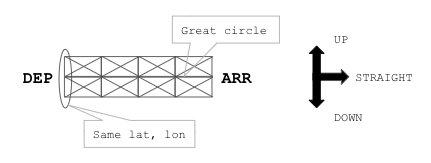

### State

- Aircraft position on the graph 
- Aircraft trajectory - trajectory followed up to this point. In particular it contains:
    - the current time
    - the current latitude
    - the current longitude
    - the current altitude
    - the current mass



In [ ]:
class State(NamedTuple):
    trajectory: pd.DataFrame
    pos: Tuple[int, int]

    def __hash__(self):
        return hash(self.pos)

    def __eq__(self, other):
        return self.pos == other.pos

    def __ne__(self, other):
        return self.pos != other.pos

    def __str__(self):
        return f"[{self.trajectory.iloc[-1]['ts']:.2f} \
            {self.pos} \
            {self.trajectory.iloc[-1]['alt']:.2f} \
            {self.trajectory.iloc[-1]['fuel']:.2f}]"

### Action
- The various options the Aircraft can choose to navigate on the graph. In this case, we have three possible actions: UP, DOWN and STRAIGHT

In [ ]:
class Action(Enum):
    up = -1
    straight = 0
    down = 1

### Goal
- The goal is all the points that share the arrival location (latitude, longitude) ARR

### Reward

The reward (or cost) associated to any action is the value of the objective function for the given transition (often fuel consumption or time)

### Starting State
The starting position of the aircraft is the departure airport location (latitude, longitude) DEP. The aircraft is located on the great circle (middle line).


We also specify the type of states, observations, events, transition values, ... 

This is needed so that the various solvers know how to work properly with this domain.

### Domain type


Then we define the domain type from a base template (`DeterministicPlanningDomain`) with optional refinements (`UnrestrictedActions` and `Renderable`). This corresponds to the following characteristics:
- `DeterministicPlanningDomain`:
    - only one agent
    - deterministic starting state
    - handle only actions
    - actions are sequential
    - deterministic transitions
    - white box transition model
    - goal states are defined
    - positive costs (i.e. negative rewards)
    - fully observable
- `UnrestrictedActions`: all actions are available at each step
- `Renderable`: can be displayed

In [ ]:
class D(DeterministicPlanningDomain, UnrestrictedActions, Renderable):
    T_state = State  # Type of states
    T_observation = State  # Type of observations
    T_event = Action  # Type of events
    T_value = float  # Type of transition values (rewards or costs)
    T_predicate = bool  # Type of transition predicates (terminal states)
    T_info = None  # Type of additional information in environment outcome
    T_agent = Union  # Type of agent

Once the domain type `D` has been defined, one can see from the [code generator]() that the following methods need to be implemented:

```
def _get_next_state(self, memory: D.T_state, action: D.T_event):
    pass
    
def _get_transition_value(self, memory: D.T_state, action: D.T_event, next_state: Optional[D.T_state] = None)
    pass
    
def _is_terminal(self, state: D.T_state):
    pass
    
def _get_action_space_(self):
    pass
    
def _get_goals_(self):
    pass
    
def _state_reset(self):
    pass
    
def _get_observation_space_(self):
    pass
    
def _render_from(self, memory: D.T_state, **kwargs: Any):
    pass
```

### Flight domain implementation

The class below implements all methods highlighted above as well as the two following helper methods:
 - one to generate the mesh on which the aircraft can navigate,
 - one to guide the solver make decision by providing a heuristic
 
The class provides also a constructor that takes few parameters defining the flight, namely:
 - origin airport (either ICAO [code](https://en.wikipedia.org/wiki/List_of_airports_by_ICAO_code:_A) or tuple with latitude & longitude),
 - destination airport using the same format
 - ICAO aircraft [type](https://en.wikipedia.org/wiki/List_of_aircraft_type_designators)
 - aircraft take-off weight as a percentage of the maximum take-off weight [MTOW](https://en.wikipedia.org/wiki/Maximum_takeoff_weight)
 - a wind interpolator (see below)
 - an objective functions (as defined by `open-ap`, can be `time`, `fuel`, `ci:xx`)

In [ ]:
class FlightPlanningDomain(D):
    def __init__(
        self,
        origin: Union[str, tuple],
        destination: Union[str, tuple],
        actype: str,
        m0: float = 0.8,
        wind_interpolator: WindInterpolator = None,
        objective: Union[str, tuple] = "fuel",
    ):
        """A simple class to compute a flight plan.

        Parameters
        ----------
        origin: Union[str, tuple])
            ICAO or IATA code of airport, or tuple (lat, lon)
        destination: Union[str, tuple]
            ICAO or IATA code of airport, or tuple (lat, lon)
        aircraft : Aircraft
            Describe the aircraft.
        windfield: pd.DataFrame
            Wind field data. Defaults to None.
        objective: str
            The objective of the flight. Defaults to "fuel".
            for climb, cruise and descent.
        """
        if isinstance(origin, str):
            ap1 = airport(origin)
            self.lat1, self.lon1 = ap1["lat"], ap1["lon"]
        else:
            self.lat1, self.lon1 = origin

        if isinstance(destination, str):
            ap2 = airport(destination)
            self.lat2, self.lon2 = ap2["lat"], ap2["lon"]
        else:
            self.lat2, self.lon2 = destination
        #
        self.objective = objective

        self.wind_ds = None
        if wind_interpolator:
            self.wind_ds = wind_interpolator.get_dataset()

        # Build network between top of climb and destination airport
        self.np: int = 41
        self.nc: int = 11
        self.network = self.get_network(
            LatLon(self.lat1, self.lon1),
            LatLon(self.lat2, self.lon2),
            self.np,
            self.nc,
        )

        ac = aircraft(actype)
        self.start = State(
            pd.DataFrame(
                [
                    {
                        "ts": 0,
                        "lat": self.lat1,
                        "lon": self.lon1,
                        "mass": m0 * ac["limits"]["MTOW"],
                        "mach": ac["cruise"]["mach"],
                        "fuel": 0.0,
                        "alt": ac["cruise"]["height"],
                    }
                ]
            ),
            (0, self.nc // 2),
        )

        self.fuel_flow = FuelFlow(actype).enroute

    def _get_next_state(self, memory: D.T_state, action: D.T_event) -> D.T_state:
        """
        Compute the next state from:
          - memory: the current state
          - action: the action to take
        """
        trajectory = memory.trajectory.copy()

        # Set intermediate destination point
        next_x, next_y = memory.pos

        next_x += 1

        if action == Action.up:
            next_y += 1
        if action == Action.down:
            next_y -= 1

        # Aircraft stays on the network
        if next_x >= self.np or next_y < 0 or next_y >= self.nc:
            return memory

        # Concatenate the two trajectories

        to_lat = self.network[next_x][next_y].lat
        to_lon = self.network[next_x][next_y].lon
        trajectory = flying(
            trajectory.tail(1), (to_lat, to_lon), self.wind_ds, self.fuel_flow
        )

        state = State(
            pd.concat([memory.trajectory, trajectory], ignore_index=True),
            (next_x, next_y),
        )
        return state

    def _get_transition_value(
        self,
        memory: D.T_state,
        action: D.T_event,
        next_state: Optional[D.T_state] = None,
    ) -> Value[D.T_value]:
        """
        Get the value (reward or cost) of a transition.

        Set cost to distance travelled between points
        """

        assert memory != next_state, "Next state is the same as the current state"

        cost = distance(
            memory.trajectory.tail(1)["lat"],
            memory.trajectory.tail(1)["lon"],
            next_state.trajectory.iloc[-1]["lat"],
            next_state.trajectory.iloc[-1]["lon"],
        )

        # return Value(cost=1)
        return Value(cost=cost)

    def _get_initial_state_(self) -> D.T_state:
        """
        Get the initial state.

        Set the start position as initial state.
        """
        return self.start

    def _get_goals_(self) -> Space[D.T_observation]:
        """
        Get the domain goals space (finite or infinite set).

        Set the end position as goal.
        """
        return ListSpace([State(None, (self.np - 1, j)) for j in range(self.nc)])

    def _is_terminal(self, state: State) -> D.T_predicate:
        """
        Indicate whether a state is terminal.

        Stop an episode only when goal reached.
        """
        return state.pos[0] == self.np - 1

    def _get_applicable_actions_from(self, memory: D.T_state) -> Space[D.T_event]:
        """
        Get the applicable actions from a state.
        """
        x, y = memory.pos

        space = []
        if x < self.np - 1:
            space.append(Action.straight)
            if y + 1 < self.nc:
                space.append(Action.up)
            if y > 0:
                space.append(Action.down)

        return ListSpace(space)

    def _get_action_space_(self) -> Space[D.T_event]:
        """
        Define action space.
        """
        return EnumSpace(Action)

    def _get_observation_space_(self) -> Space[D.T_observation]:
        """
        Define observation space.
        """
        return MultiDiscreteSpace([self.np, self.nc])

    def _render_from(self, memory: State, **kwargs: Any) -> Any:
        """
        Render visually the map.

        Returns:
            matplotlib figure
        """

        return plot_trajectory(
            self.lat1, self.lon1, self.lat2, self.lon2, memory.trajectory, self.wind_ds
        )

    def heuristic(self, s: D.T_state) -> Value[D.T_value]:
        """Heuristic to be used by search algorithms.

        Here fuel consumption to reach target.

        """
        lat = s.trajectory.iloc[-1]["lat"]
        lon = s.trajectory.iloc[-1]["lon"]
        # Compute distance in meters
        distance_to_goal = distance(lat, lon, self.lat2, self.lon2)
        cost = distance_to_goal

        return Value(cost=cost)

    def get_network(self, p0: LatLon, p1: LatLon, np: int, nc: int):
        np2 = np // 2
        nc2 = nc // 2

        distp = 10 * p0.distanceTo(p1) / np / nc  # meters

        pt = [[None for j in range(nc)] for i in range(np)]

        # set boundaries
        for j in range(nc):
            pt[0][j] = p0
            pt[np - 1][j] = p1

        # direct path between p0 and p1
        for i in range(1, np - 1):
            bearing = pt[i - 1][nc2].initialBearingTo(p1)
            total_distance = pt[i - 1][nc2].distanceTo(pt[np - 1][nc2])
            pt[i][nc2] = pt[i - 1][nc2].destination(total_distance / (np - i), bearing)

        bearing = pt[np2 - 1][nc2].initialBearingTo(pt[np2 + 1][nc2])
        pt[np2][nc - 1] = pt[np2][nc2].destination(distp * nc2, bearing + 90)
        pt[np2][0] = pt[np2][nc2].destination(distp * nc2, bearing - 90)

        for j in range(1, nc2 + 1):
            # +j (left)
            bearing = pt[np2][nc2 + j - 1].initialBearingTo(pt[np2][nc - 1])
            total_distance = pt[np2][nc2 + j - 1].distanceTo(pt[np2][nc - 1])
            pt[np2][nc2 + j] = pt[np2][nc2 + j - 1].destination(
                total_distance / (nc2 - j + 1), bearing
            )
            # -j (right)
            bearing = pt[np2][nc2 - j + 1].initialBearingTo(pt[np2][0])
            total_distance = pt[np2][nc2 - j + 1].distanceTo(pt[np2][0])
            pt[np2][nc2 - j] = pt[np2][nc2 - j + 1].destination(
                total_distance / (nc2 - j + 1), bearing
            )
            for i in range(1, np2):
                # first halp (p0 to np2)
                bearing = pt[i - 1][nc2 + j].initialBearingTo(pt[np2][nc2 + j])
                total_distance = pt[i - 1][nc2 + j].distanceTo(pt[np2][nc2 + j])
                pt[i][nc2 + j] = pt[i - 1][nc2 + j].destination(
                    total_distance / (np2 - i + 1), bearing
                )
                bearing = pt[i - 1][nc2 - j].initialBearingTo(pt[np2][nc2 - j])
                total_distance = pt[i - 1][nc2 - j].distanceTo(pt[np2][nc2 - j])
                pt[i][nc2 - j] = pt[i - 1][nc2 - j].destination(
                    total_distance / (np2 - i + 1), bearing
                )
                # second half (np2 to p1)
                bearing = pt[np2 + i - 1][nc2 + j].initialBearingTo(pt[np - 1][nc2 + j])
                total_distance = pt[np2 + i - 1][nc2 + j].distanceTo(
                    pt[np - 1][nc2 + j]
                )
                pt[np2 + i][nc2 + j] = pt[np2 + i - 1][nc2 + j].destination(
                    total_distance / (np2 - i + 1), bearing
                )
                bearing = pt[np2 + i - 1][nc2 - j].initialBearingTo(pt[np - 1][nc2 - j])
                total_distance = pt[np2 + i - 1][nc2 - j].distanceTo(
                    pt[np - 1][nc2 - j]
                )
                pt[np2 + i][nc2 - j] = pt[np2 + i - 1][nc2 - j].destination(
                    total_distance / (np2 - i + 1), bearing
                )
        return pt

### Domain factory

Because some of the solvers are parallel, one need to be able to create similar domains easily. This is done through a factory which is a simple `lambda` function.
For creating this function, we need to define the parameters of our flight.

In our case, we will flight in `A380` from Charles de Gaulle airport, France (`LFPG`) to Changi airport, Singapore (`WSSS`). By default, the take off weight is 80% of the `MTOW`

In [ ]:
domain_factory = lambda: FlightPlanningDomain(
    "LFPG", "WSSS", "A388", wind_interpolator=wind_interpolator
)

## Solving the problem

Now that we have defined the domain we can proceed with finding a solution for it.

### Finding suitable solvers
The `scikit-decide` library includes a lot of solvers. We can use `match_solvers` function to show available solvers that fit the characteristics of the defined domain, according to the mixin classes used to define the [domain type](#Domain-type).

In [ ]:
domain = domain_factory()

match_solvers(domain=domain)

In the following, we will be using LazyAstar (A*) which is a solver coming from the path planning community.

### Solver instantiation

As explained earlier, we use the Boundary Extension Encoding state features `bee2_features` so that IW can dynamically increase state variable intervals. In other domains, other state features might be more suitable.

In [ ]:
solver = Astar(heuristic=lambda d, s: d.heuristic(s))

### Training solver on domain

In [ ]:
%%time
FlightPlanningDomain.solve_with(solver, domain_factory)

### Rolling out a solution

We have to slightly modify the roll out function as observations for the new domain are now wrapped in a `GymDomainProxyState` to make them serializable. So to get access to the underlying numpy array, we need to look for `observation._state`.

In [ ]:
%%time

pause_between_steps = None
max_steps = 100

solver.reset()
observation = domain.reset()

print("Starting planning")

# Initialize image
figure = domain.render(observation)
plt.show()

# loop until max_steps or goal is reached
for i_step in range(1, max_steps + 1):
    if pause_between_steps is not None:
        sleep(pause_between_steps)

    # choose action according to solver
    action = solver.sample_action(observation)
    # get corresponding action
    outcome = domain.step(action)
    observation = outcome.observation

    # update image
    plt.clf()  # clear figure
    clear_output(wait=True)
    figure = domain.render(observation)
    plt.show()

    # final state reached?
    if domain.is_terminal(observation):
        break

# goal reached?
is_goal_reached = domain.is_goal(observation)
if is_goal_reached:
    print(f"Goal reached in {i_step} steps!")
else:
    print(f"Goal not reached after {i_step} steps!")

### Cleaning up

In [ ]:
solver._cleanup()

## Conclusion

We saw that it is possible to define in few lines of code a real life application. Thanks to the formalism `scikit-decide` and its rich solver library, it is then possible to find a solution very quickly.